# KNN: k-nearest neighbours

En este apartado revisaremos el algoritmo de knn. Este algoritmo es del tipo supervisado y nos permite realizar una clasificación/clusterización de nuestros datos de entrada.<br><br>
El algoritmo se compone de los siguientes pasos:<br>
1. Determinar un valor de **k** vecinos, adecuado para nuestro conjunto de datos.
2. Iterar cada punto de nuestro conjunto de prueba para determinar sus **k** vecinos más cercanos.
3. Asignar a dicho punto la clase que más se haya repetido dentro de sus vecinos más cercanos.
4. Evaluar la precisión del clasificador.

## Recolectar
Comenzamos por importar librerías, leer el archivo y desplegar una muestra de los datos. En esta ocasión utilizaremos nuestro conjunto de datos llamado **heart_disease**, el cual contiene datos de problemas cardiacos de algunos pacientes junto con otros parámetros médicos y físicos de cada paciente.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv("EnfCoronaria.csv")
print("Dimensión:",df.shape)
df.head()

Dimensión: (462, 5)


,sbp,famhist,obesity,age,chd
0,160,1,25.30,52,1
1,144,0,28.87,63,1
2,118,1,29.14,46,0
3,170,1,31.99,58,1
4,134,1,25.99,49,1


Utilizamos la librería **seaborn** para visualizar rápidamente y de forma gráfica el comportamiento entre las variables en pares.

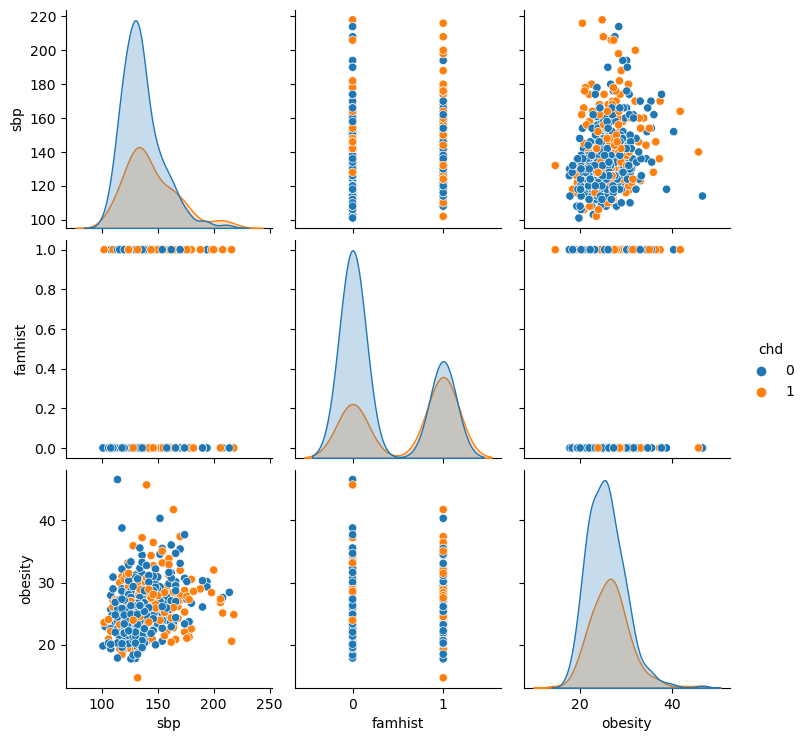

In [10]:
sns.pairplot(df, vars=df.columns[:3], hue=df.columns[-1])

## Preparar
Creamos una función para escalar los valores entre 0 y 1. Para que las distancias no estén cesgadas por las dimensiones de las mismas.

In [11]:
def scale_zero_one(df):
    df2=df.copy()
    for col in df2.columns:
        minCol=min(df[col])
        maxCol=max(df[col])
        df2[col]=(df[col]-minCol)/(maxCol-minCol)
    return df2
df2=scale_zero_one(df)
df2.head()

,sbp,famhist,obesity,age,chd
0,0.504274,1.0,0.332497,0.755102,1.0
1,0.367521,0.0,0.444479,0.979592,1.0
2,0.145299,1.0,0.452949,0.632653,0.0
3,0.589744,1.0,0.542346,0.877551,1.0
4,0.282051,1.0,0.354141,0.693878,1.0


## Analizar
Nuevamente revisamos los datos y observamos que no hay una diferencia significativa para este conjunto de datos.

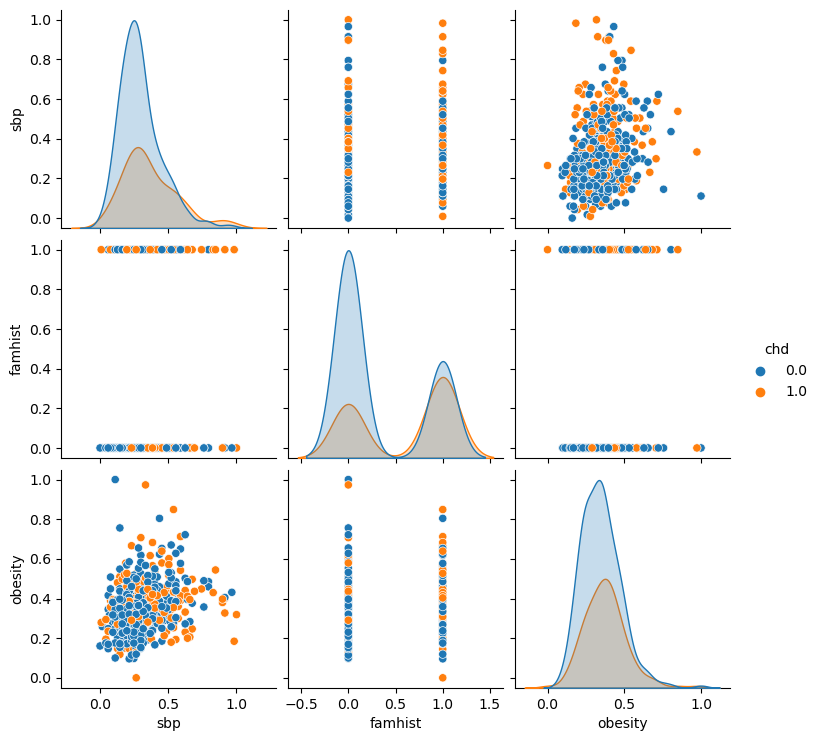

In [12]:
sns.pairplot(df2, vars=df2.columns[:3], hue=df2.columns[-1])

Procedemos a crear una clase que será nuestro clasificador KNN, en él agregamos métodos que nos faciliten el uso de nuestro clasificador.<br>
**Nota:** No todos los métodos son necesarios para que funcione el clasificador KNN. A continuación sólo se explicarán los que son indispensables.<br><br>
En nuestro método **\__init__** creamos las variables iniciales del clasificador:<br>
- **best_k**: Guardaremos la k que de un mayor rendimiento durante el entrenamiento del clasificaor.
- **best_acc**: La precisión asociada a la k elegida.
- **origin**: Servirá para definir el punto de origen para medir distancias.
- **distances**: Distancias de cada punto al origen.
- **X_pool**: Conjunto X para comparación, adquirido en el entrenamiento.
- **y_pool**: valor objetivo asociado a la variable **X_pool**.
<br><br>
El método **setOrigin** nos permite cambiar el origen actual.<br><br>
Después **setDistances** es el que se encarga de calcular las distancias de cada punto al origen.<br><br>
**distancePoints** es usado por **setDistances** para hacer en sí el cálculo y regresarlo para que sea guardado.
El método **fit** es uno de los más importantes, ya que se encarga del entrenamiento del clasificador. Dentro de **fit** se usa **evaluate** para revisar la precisión que tiene cada cantidad de vecinos y así determinar la mejor. Aquí tambien se utiliza la función **belongsTo** que determina a que clase pertence cada punto en realidad.<br><br>
Por último, **predict** se encarga de determinar a que conjunto pertenece cada punto de prueba, de acuerdo a la **k** definida en el entrenamieto.

In [13]:
class myKNN():
    '''
    Éste es mi clasificador sencillo de vecinos más cercanos. Busca la mejor k en intervalos de 
    un factor determinado (predeterminado a 5).
    '''
    def __init__(self):
        import numpy as np
        self.best_k=2
        self.best_acc=0
        self.origin=np.array([])
        self.distances=np.array([])
        self.X_pool=[]
        self.y_pool=[]
    
    def setOrigin(self, p1):
        self.origin=p1
            
    def distancePoints(self, p1, p2):
        mySum=0
        for x in range(p1.shape[0]):
            mySum+=((p2[x]-p1[x])**2)
        return mySum**(1/2)
            
    def getOrigin(self):
        return self.origin
    
    def setDistances(self, X):
        self.distances=np.array([])
        for x in range(X.shape[0]):
            self.distances=np.append(self.distances, self.distancePoints(self.origin, X[x,:]))
            
    def getDistances(self):
        return self.distances
    
    def belongsTo(self, sel):
        uniqueVars=np.unique(sel)
        counter=np.zeros(uniqueVars.shape[0])
        for ind in sel:
            counter[np.where(ind == uniqueVars)[0][0]]+=1
        higherCount=np.where(np.max(counter)==counter)[0][0]
        cluster=uniqueVars[higherCount]
        return cluster
    
    def evaluate(self, k, factor):
        X_aux=self.X_pool.copy()
        index=np.arange(0,X_aux.shape[0])
        train_index=np.random.permutation(index)
        train_index=train_index[:int(0.2*index.shape[0])]
        accuracy=np.zeros(k)
        for ind in train_index:
            self.setOrigin(X_aux[ind])
            self.setDistances(np.delete(X_aux, ind, axis=0))
            db=np.zeros([(index.shape[0]-1),3])
            db[:,0]=np.delete(index, ind, axis=0)
            db[:,1]=self.distances
            db[:,2]=self.y_pool[index!=ind]
            db=db[db[:,1].argsort()]
            if self.belongsTo(db[:k*factor,2])==self.y_pool[ind]:
                accuracy[k-1]+=1
        accuracy[k-1]=accuracy[k-1]/train_index.shape[0]
        print("Precisión:",accuracy[k-1],'/',1,end="\n\n")
        if self.best_acc<accuracy[k-1]:
            self.best_acc=accuracy[k-1]
            self.best_k=k*factor
    
    def fit(self, X, y, factor=5):
        self.X_pool=X
        self.y_pool=y
        for k in range(1,10):
            print("k calculada:",k*factor)
            self.evaluate(k, factor)
        print("k determinada:",self.best_k, "Precisión esperada:",self.best_acc)
            
    def predict(self, X):
        predictions=np.zeros(X.shape[0])
        cluster=[]
        nclusters=np.unique(self.y_pool).shape[0]
        for c in range(nclusters):
            cluster.append([])
        X_aux=X.copy()
        index_pool=np.arange(0,self.X_pool.shape[0])
        index=np.arange(0,X_aux.shape[0])
        for ind in index:
            self.setOrigin(X_aux[ind])
            self.setDistances(self.X_pool)
            db=np.zeros([(index_pool.shape[0]),3])
            db[:,0]=index_pool
            db[:,1]=self.distances
            db[:,2]=self.y_pool
            db=db[db[:,1].argsort()]
            cluster[int(self.belongsTo(db[:(self.best_k),2]))].append(ind)
            predictions[ind]=int(self.belongsTo(db[:(self.best_k),2]))
        return predictions, np.array(cluster)

Revisemos un resumen de nuestra clase por medio de la función **help**

In [14]:
help(myKNN)

Help on class myKNN in module __main__:

class myKNN(builtins.object)
 |  Éste es mi clasificador sencillo de vecinos más cercanos. Busca la mejor k en intervalos de 
 |  un factor determinado (predeterminado a 5).
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  belongsTo(self, sel)
 |  
 |  distancePoints(self, p1, p2)
 |  
 |  evaluate(self, k, factor)
 |  
 |  fit(self, X, y, factor=5)
 |  
 |  getDistances(self)
 |  
 |  getOrigin(self)
 |  
 |  predict(self, X)
 |  
 |  setDistances(self, X)
 |  
 |  setOrigin(self, p1)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



Podemos ver que todos los métodos aparecen, así como nuestra descripción de la clase.<br>
Ahora continuaremos con un pequeño análisis de nuestro conjunto de datos.<br><br>
Tenemos 462 observaciones para este conjunto de datos por lo cual tomaremos el 80% para entrenamiento y el 20% para pruebas.<br><br>
Entrenamiento - 370<br>
Prueba        - 92<br><br>
De igual manera hay que considerar que debemos guardar nuestro valor objetivo en una variable **y**. Adicionalmente guardando el resto de los datos en una variable **X**. Cada una con su partición **train** y **test**.

In [15]:
y_train, y_test = df["chd"][:370], df["chd"][370:]
X_train, X_test = df.values[:370,:], df.values[370:,:]
print("Valores en X")
print("Entrenamiento:", X_train.shape, "Prueba:", X_test.shape, end='\n\n')
print("Valores en y")
print("Entrenamiento:", y_train.shape, "Prueba:", y_test.shape)

Valores en X
Entrenamiento: (370, 5) Prueba: (92, 5)

Valores en y
Entrenamiento: (370,) Prueba: (92,)


## Entrenar
Ahora hacemos uso de la clase creada previamente y creamos el clasificador.<br>
También realizamos el entrenamiento con los conjuntos de entrenamiento.

In [16]:
clf=myKNN()
clf.fit(X_train, y_train)

k calculada: 5
Precisión: 0.6081081081081081 / 1

k calculada: 10
Precisión: 0.7297297297297297 / 1

k calculada: 15
Precisión: 0.5945945945945946 / 1

k calculada: 20
Precisión: 0.6621621621621622 / 1

k calculada: 25
Precisión: 0.527027027027027 / 1

k calculada: 30
Precisión: 0.6891891891891891 / 1

k calculada: 35
Precisión: 0.6081081081081081 / 1

k calculada: 40
Precisión: 0.6216216216216216 / 1

k calculada: 45
Precisión: 0.6621621621621622 / 1

k determinada: 10 Precisión esperada: 0.7297297297297297


## Probar
Creamos una función para facilitar el cálculo de la precisión obtenida por nuestro clasificador. En la cual se determina la cantidad de verdaderos positivos.

In [17]:
def accuracy(y, predictions):
    return (np.array([y==predictions]).sum())/y.shape[0]

Obtenemos las predicciones para nuestro conjunto de prueba y posteriormente desplegamos la presición.<br>
En esta sección también obtenemos como variable los clusters con los índices obtenidos en el proceso de predicción.

In [18]:
predictions, clusters=clf.predict(X_test)
print("Precisión:")
accuracy(y_test, predictions)

Precisión:


/var/folders/g5/4qf8flcn2w74szbtkfs707780000gn/T/ipykernel_52749/1025167805.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return predictions, np.array(cluster)


0.6630434782608695

Finalmente usamos los clusters obtenidos durante la predicción para comparar con el grupo real que ya conocemos. Seleccionamos 2 dimensiones para una fácil visualización. Se usará la columna 0 y la 2.

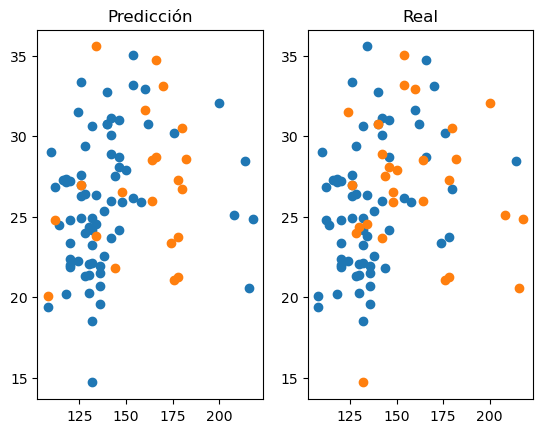

In [19]:
plt.subplot(1,2,1)
for i in range(clusters.shape[0]):
    plt.scatter(X_test[clusters[i],0],X_test[clusters[i],2])
plt.title("Predicción")
plt.subplot(1,2,2)
for i in range(np.unique(clf.y_pool).shape[0]):
    plt.scatter(X_test[i==y_test,0],X_test[i==y_test,2])
plt.title("Real")
plt.show()

Puede observarse que los grupos son muy parecidos (recuerda que el clasificador tiene un 72% de presición) por lo cual el clasificador construido tiene un desempeño aceptable, aunque aún puede ser mejorado. Intenta modificar algunas secciones del código para que se haga una mejor predicción.<br><br>
**Nota**: Puede ser posible que debido a que en este ejemplo las clases están muy sobrepuestas, no se pueda tener una precisión muy alta en este conjunto de datos. Intenta con otro conjunto de datos para comparar tus resultados.

## Usar
Hemos creado un clasificador **KNN** sencillo que nos permite determinar la clase a la que pertenece un conjuto de puntos, dado otro conjunto de puntos conocido por medio de los puntos adyacentes más cercanos.<br>
Este clasificador puede mejorar, haciendo más eficiente la búsqueda de la cantidad de vecinos más cercanos que dan un mejor resultado. Usa el código proporcionado e intenta mejorar el clasificador.<br><br>
Dentro de los usos que tiene knn, se encuentra la agrupación de datos que tiene la característica de estar muy sobrepuestos. Esto presenta una ventaja frente a otros algoritmos, ya que cuando los grupos no sean separables, el algoritmo tendrá un buen rendimiento si se ha realizado un buen entrenamiento.